In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

sys.path.append('..')
from backend.DB.db import Database

In [2]:
db = Database()

### Aggregation of review sentiments by topic

In [3]:
sql = '''
SELECT topic_name, 
       COUNT(review_id) as num_reviews,
       AVG(sentiment) as mean_sentiment,
       MAX(sentiment) as max_sentiment,
       MIN(sentiment) as min_sentiment,
       SUM(angry) as count_angry 
FROM cooked_reviews
WHERE relevant = true
GROUP BY topic_name
ORDER BY mean_sentiment ASC
'''

results = db.query_sql(sql)
result_set = [{'topic': row[0], 
               'num_reviews': row[1],
               'avg_sentiment': row[2],
               'max_sentiment': row[3],
               'min_sentiment': row[4],
               'angry_guests': row[5]} for row in results]
results_df = pd.DataFrame(result_set)
results_df

,topic,num_reviews,avg_sentiment,max_sentiment,min_sentiment,angry_guests
0,housekeeping,47,3.744681,5,0,2
1,value,89,3.988764,5,1,4
2,hotel condition,78,4.000000,5,1,3
3,frontdesk service,71,4.028169,5,1,5
4,amenities,66,4.136364,5,1,1


How many are angry under each topic?

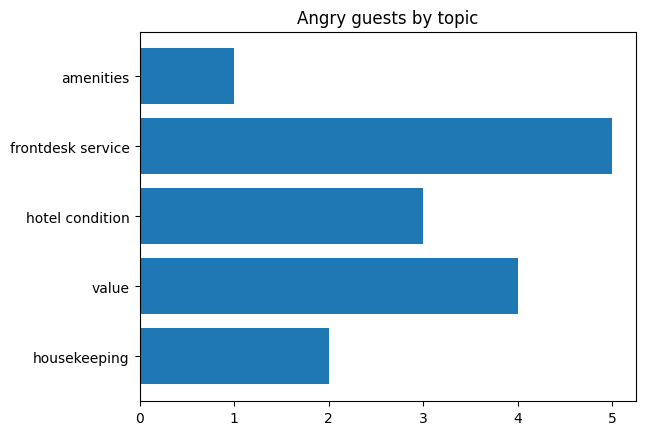

In [4]:
plt.barh(results_df['topic'], results_df['angry_guests'])
plt.title('Angry guests by topic')
plt.show()

### Distribution of sentiments for each topic

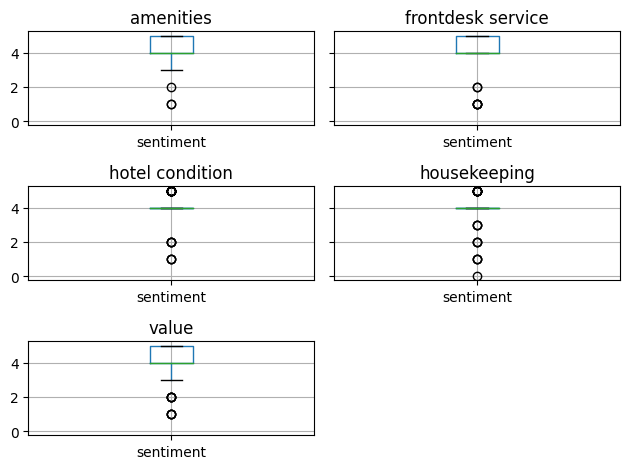

In [5]:
sql = '''
SELECT topic_name, sentiment
FROM cooked_reviews
WHERE relevant = true
ORDER BY topic_name;
'''

results = db.query_sql(sql)
data = [{'topic': t, 'sentiment': s} for t, s in results]
sentiments_df = pd.DataFrame(data)

sentiments_grouped = sentiments_df.groupby(by='topic')
sentiments_grouped.boxplot()
plt.tight_layout()
plt.title("Sentiment by topic")
plt.show()

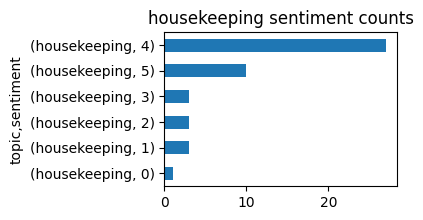

In [6]:
def barplot(df, topic):
   plt.figure(figsize=(3,2))
   df_filtered = df[df['topic'] == topic]
   counts = df_filtered.value_counts()
   counts = counts.sort_values()
   counts.plot(kind='barh')
   plt.title(f'{topic} sentiment counts')
   plt.show()

data = barplot(sentiments_df, 'housekeeping')


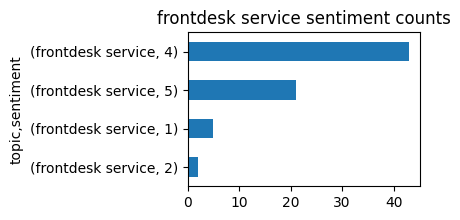

In [7]:
barplot(sentiments_df, 'frontdesk service')

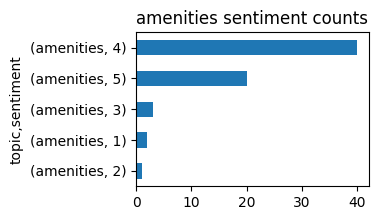

In [8]:
barplot(sentiments_df, 'amenities')

### Angry Guests

Look at categorized reviews flagged as guest being angry from sentiment analysis by GPT

In [9]:
sql = '''
SELECT l.location_description, cr.source_name, cr.review_id, cr.topic_name, cr.sentiment, cr.summary
FROM cooked_reviews AS cr
JOIN locations as l
ON cr.source_name = l.source_name AND  cr.locations_location = l.locations_location
WHERE cr.angry > 0;
'''

results = db.query_sql(sql)
result_set = [{'place': row[0], 
               'review_source': row[1],
               'review_id': row[2],
            'topic': row[3],
            'sentiment': row[4],
            'summary': row[5]} for row in results]
results_df = pd.DataFrame(result_set)

sents = ['N/A', 'very bad', 'bad', 'neutral', 'good', 'very good']
results_df['sentiment'] = results_df['sentiment'].apply(lambda x: sents[x])
results_df

,place,review_source,review_id,topic,sentiment,summary
0,Hotel Moab Downtown,tripadvisor,862481775,housekeeping,very bad,The guest had to clean the room when they arri...
1,Hotel Moab Downtown,tripadvisor,841352567,hotel condition,very bad,The guest was angry about the hotel condition ...
2,Hotel Moab Downtown,tripadvisor,841352567,value,very bad,The guest was angry about the value as they wo...
3,Hampton Inn,tripadvisor,886905031,frontdesk service,bad,The guest had a negative experience during che...
4,Hampton Inn,tripadvisor,894562457,hotel condition,very bad,The guest was very unhappy with the hotel's co...
5,Gonzo Inn,tripadvisor,895909597,value,bad,"The guest was unhappy with the breakfast, whic..."
6,Gonzo Inn,tripadvisor,895313844,housekeeping,very bad,The guest was unhappy with the housekeeping se...
7,Gonzo Inn,tripadvisor,898168765,amenities,very bad,The guest mentioned that there were bugs in th...
8,Gonzo Inn,tripadvisor,898168765,frontdesk service,very bad,The guest mentioned that when they called the ...
9,Gonzo Inn,tripadvisor,898168765,hotel condition,very bad,The guest described the hotel as having bugs e...


### Write as a review by  review

In [24]:
from collections import defaultdict

ordered_results = defaultdict(list)
for row in result_set:
    key = (row['place'], row['review_source'], row['review_id'])
    ordered_results[key].append((row['topic'], row['sentiment'], row['summary']))

for key in ordered_results.keys():
    print(f'\n{key[0]} Review source: {key[1]} Review ID: {key[2]}')
    print('------------------------------------------------------------------------------')

    for item in ordered_results[key]:
        sentiment = sents[item[1]]
        print(f'Topic: {item[0]}\nSentiment: {sentiment}\nSummary: {item[2]}\n')


Hotel Moab Downtown Review source: tripadvisor Review ID: 862481775
------------------------------------------------------------------------------
Topic: housekeeping
Sentiment: very bad
Summary: The guest had to clean the room when they arrived. The nightstand and desk were not cleaned with cleaners in a while. The janitorial service took this rating down.


Hotel Moab Downtown Review source: tripadvisor Review ID: 841352567
------------------------------------------------------------------------------
Topic: hotel condition
Sentiment: very bad
Summary: The guest was angry about the hotel condition as the entire building was infested with baby roaches.

Topic: value
Sentiment: very bad
Summary: The guest was angry about the value as they would not recommend the place even to people they don't like due to the roach infestation.


Hampton Inn Review source: tripadvisor Review ID: 886905031
------------------------------------------------------------------------------
Topic: frontdesk s